## Импорт необходимых библиотек

In [67]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

## Конфигурация PyTorch

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


In [69]:
# Параметры модели
DATA_PATH = "dataset" # Путь датасета
BATCH_SIZE = 16 # Размер батча
EPOCHS = 30 # Количество эпох
LR = 0.001 # Learning rate
IMG_SIZE = 256 # Размер входных изображений

## Класс, описывающий датасет

In [70]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

## Аугментация данных

In [71]:
# Аугментация данных
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

## Загрузка датасета

In [72]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [73]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

## Разделение на обучающую и тестовую выборку, загрузка данных

In [74]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Функция по расчету необходимых метрик

In [75]:
# Метрики
def calculate_metrics(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()
    masks = (masks > 0.5).float()
    batch_ious, batch_dices = [], []

    for i in range(outputs.shape[0]):
        output = outputs[i]
        mask = masks[i]
        intersection = (output * mask).sum()
        union = (output + mask).sum() - intersection
        total = output.sum() + mask.sum()
        iou = (intersection / union).item() if union != 0 else float(output.sum() == 0 and mask.sum() == 0)
        dice = (2. * intersection / total).item() if total != 0 else 1.0
        batch_ious.append(iou)
        batch_dices.append(dice)

    return np.mean(batch_ious), np.mean(batch_dices)

## Модель U-net

In [76]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn

# Модель UNet
class UNetSM(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512, 1024]):
        super(UNetSM, self).__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        self.decoder = nn.ModuleList()
        self.upconv = nn.ModuleList()

        # Encoder
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self._block(features[-1], features[-1]*2)
        
        # Decoder
        for feature in reversed(features):
            self.upconv.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature*2, feature))

        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        encs = []

        # Encoder path
        for encode in self.encoder:
            x = encode(x)
            encs.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder path
        encs = encs[::-1]
        for i in range(len(self.upconv)):
            x = self.upconv[i](x)
            enc_skip = encs[i]
            if x.shape != enc_skip.shape:
                x = torch.nn.functional.interpolate(x, size=enc_skip.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat((enc_skip, x), dim=1)
            x = self.decoder[i](x)

        return self.final(x)

    @staticmethod
    def _block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


## Обучение

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(images, masks, outputs, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(images))):
        # Исходное изображение
        plt.subplot(num_samples, 3, i*3 + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        if img.shape[2] == 3:  # RGB
            plt.imshow(img)
        else:  # Grayscale
            plt.imshow(img[:, :, 0], cmap='gray')
        plt.title(f"Input Image {i+1}")
        plt.axis('off')

        # Истинная маска
        plt.subplot(num_samples, 3, i*3 + 2)
        true_mask = masks[i].cpu().squeeze().numpy()
        plt.imshow(true_mask, cmap='gray')
        plt.title(f"True Mask {i+1}")
        plt.axis('off')

        # Предсказанная маска (с пороговой бинаризацией)
        plt.subplot(num_samples, 3, i*3 + 3)
        pred_mask = torch.sigmoid(outputs[i]).gpu().squeeze().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.float32)  # Порог 0.5
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [78]:

model = UNetSM(in_channels=3, out_channels=1)

# Создаем модель с дополнительными слоями
print(device)
modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images)
            test_loss += criterion(outputs, masks).item()
            
            batch_iou, batch_dice = calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "u-net_Mod.pth")
        print(f"Best modified_model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")



cuda
Epoch 1/30
Train Loss: 0.4796 | Test Loss: 0.4847
IoU: 0.7028 | Dice: 0.7072
------------------------
Best modified_model saved at epoch 1 with IoU: 0.7028
Epoch 2/30
Train Loss: 0.4651 | Test Loss: 0.4594
IoU: 0.7043 | Dice: 0.7076
------------------------
Best modified_model saved at epoch 2 with IoU: 0.7043
Epoch 3/30
Train Loss: 0.4634 | Test Loss: 0.4594
IoU: 0.7025 | Dice: 0.7104
------------------------
Epoch 4/30
Train Loss: 0.4599 | Test Loss: 0.4666
IoU: 0.6827 | Dice: 0.6905
------------------------
Epoch 5/30
Train Loss: 0.4568 | Test Loss: 0.4575
IoU: 0.7669 | Dice: 0.7669
------------------------
Best modified_model saved at epoch 5 with IoU: 0.7669
Epoch 6/30
Train Loss: 0.4565 | Test Loss: 0.4621
IoU: 0.6980 | Dice: 0.7073
------------------------
Epoch 7/30
Train Loss: 0.4526 | Test Loss: 0.4674
IoU: 0.7425 | Dice: 0.7433
------------------------
Epoch 8/30
Train Loss: 0.4535 | Test Loss: 0.4548
IoU: 0.7073 | Dice: 0.7174
------------------------
Epoch 9/30
Train 

## Графики

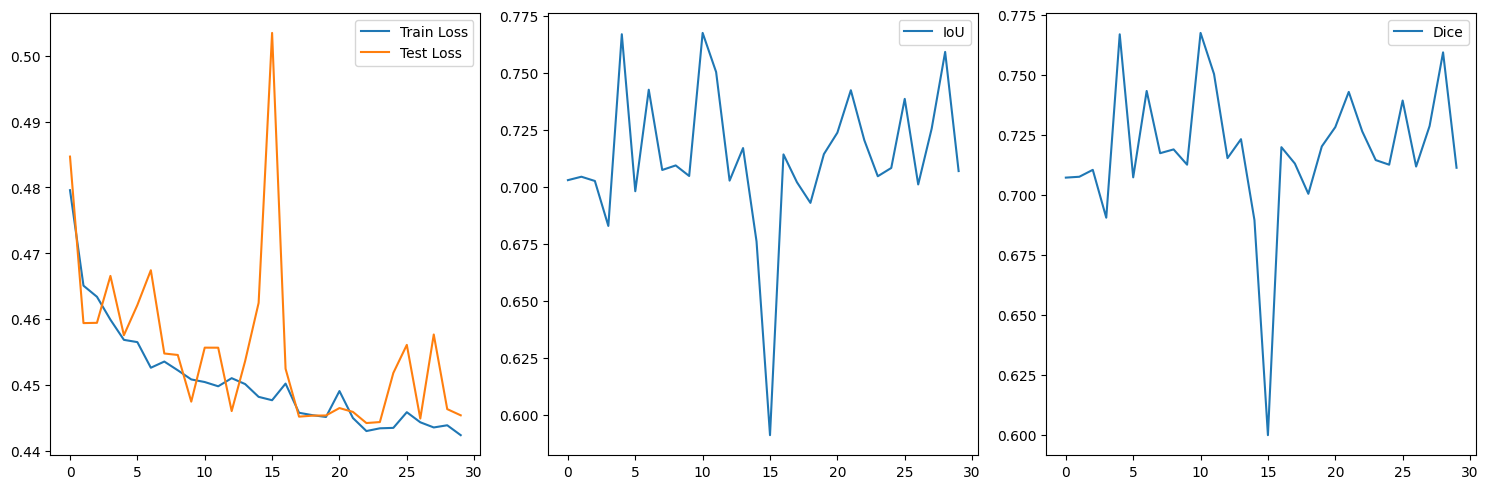

In [79]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
torch.save(modified_model.state_dict(), "u-net_Mod.pth")